#Users data EDA
The following notebook is on analyzing user data for EDA for myanimelist users.

In [0]:
#mount driver with data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Update to latest version of pandas and install pycountry package for later extracting countries from location feature

In [0]:
!pip install pandas==0.23.4
!pip install pycountry

    100% |████████████████████████████████| 10.3MB 1.9MB/s 


In [0]:
#read data
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import math
import pycountry

user_metadata = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/aniRec/data/users_filtered.csv")
user_metadata.head(10)

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
0,karthiga,2255153,3,49,1,0,0,55.31,Female,"Chennai, India",1990-04-29,NaN,2013-03-03,2014-02-04 01:32:00,7.43,0.0,3391.0
1,RedvelvetDaisuki,1897606,61,396,39,0,206,118.07,Female,Manila,1995-01-01,NaN,2012-12-13,1900-05-13 02:47:00,6.78,80.0,7094.0
2,Damonashu,37326,45,195,27,25,59,83.70,Male,"Detroit,Michigan",1991-08-01,NaN,2008-02-13,1900-03-24 12:48:00,6.15,6.0,4936.0
3,bskai,228342,25,414,2,5,11,167.16,Male,"Nayarit, Mexico",1990-12-14,NaN,2009-08-31,2014-05-12 16:35:00,8.27,1.0,10081.0
4,terune_uzumaki,327311,5,5,0,0,0,15.20,Female,"Malaysia, Kuantan",1998-08-24,NaN,2010-05-10,2012-10-18 19:06:00,9.70,6.0,920.0
5,Bas_G,5015094,35,114,6,20,175,30.81,Male,"Nijmegen, Nederland",1999-10-24,NaN,2015-11-26,1900-05-10 13:53:00,7.86,0.0,1847.0
6,HimeAria,3129315,2,87,2,0,28,20.12,Female,Poland,1996-09-26,NaN,2013-09-08,1900-04-27 10:52:00,8.23,0.0,1314.0
7,Skallington,326733,0,3,0,0,0,4.32,Male,Norberg Sweden,1991-03-15,NaN,2010-05-09,2010-05-12 06:29:00,10.00,7.0,251.0
8,Slimak,61677,79,224,0,3,84,126.17,Male,Poland,1988-02-21,NaN,2008-05-18,1900-05-01 05:04:00,7.77,2.0,7472.0
9,Elysiun,5927342,7,4,0,0,4,2.09,Male,Nebraska,1984-11-16,NaN,2016-12-25,2017-03-11 21:37:00,7.40,0.0,121.0


In [0]:
user_metadata.describe(include='all')

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
count,116132,1.161330e+05,116133.000000,116133.000000,116133.000000,116133.000000,116133.000000,1.161330e+05,116133,116127,116133,0.0,116133,116133,116133.000000,116133.000000,1.161330e+05
unique,116132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,42835,10312,NaN,4255,107613,NaN,NaN,NaN
top,narinz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,Poland,1993-01-01,NaN,2009-01-02,1900-05-13 14:11:00,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75540,1804,365,NaN,80,7,NaN,NaN,NaN
mean,NaN,1.810832e+06,14.610283,195.498807,11.338018,11.818518,74.936332,9.329691e+01,NaN,NaN,NaN,NaN,NaN,NaN,7.713389,13.991079,6.611762e+03
std,NaN,1.996139e+06,32.459424,256.533148,31.622640,31.117077,177.889249,7.636053e+03,NaN,NaN,NaN,NaN,NaN,NaN,1.538595,54.731186,7.155270e+05
min,NaN,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000e+00
25%,NaN,1.990980e+05,3.000000,47.000000,0.000000,0.000000,5.000000,2.246000e+01,NaN,NaN,NaN,NaN,NaN,NaN,7.310000,0.000000,1.349000e+03
50%,NaN,5.615770e+05,7.000000,121.000000,4.000000,3.000000,27.000000,4.990000e+01,NaN,NaN,NaN,NaN,NaN,NaN,7.880000,1.000000,3.017000e+03
75%,NaN,3.464591e+06,16.000000,253.000000,12.000000,12.000000,80.000000,9.277000e+01,NaN,NaN,NaN,NaN,NaN,NaN,8.460000,10.000000,5.642000e+03


## Removing irrelevant features

We see that access_rank is basically an empty feature and last_online is not useful information for us. So we can drop those features

In [0]:
user_metadata = user_metadata.drop(columns=['access_rank','last_online'])

##Feature engineering and synthetic data generation
Now that we have decided which features we are going to work on, let's extract some synthetic data from existing data using features with dates

In [0]:
from datetime import datetime, date
def get_num_months(x):
    if type(x['join_date']) is float:
        return np.nan
    num_months = datetime.strptime(x['join_date'],'%Y-%m-%d').date() - date.today()
    return -num_months.days/30.0
#extract number of months that user has joined myanimelist
user_metadata['num_months'] = user_metadata.apply(get_num_months,axis=1)

In [0]:
def get_age(x):
    if type(x['birth_date']) is float:
        return np.nan
    try:
        age = datetime.strptime(x['birth_date'],'%Y-%m-%d').date() - date.today()
    except:
        #one exception where '1-06-27' is given, process seperately
        age = datetime.strptime('2001-06-27','%Y-%m-%d').date() - date.today()
    return -age.days/365.0
#extract age from birth_date. 
user_metadata['age'] = user_metadata.apply(get_age,axis=1)
#drop unusally young people (obviously someone less than 5-year-old can't join a website)
user_metadata.loc[user_metadata['age']<5,'age'] = np.nan
#drop original collumns
user_metadata = user_metadata.drop(columns=['birth_date','join_date'])

In [0]:
#extract country from location feature using pycountry
def extract_country(x):
    place = np.nan
    if type(x['location']) is float:
        return place
    for country in pycountry.countries:
        if country.name in x['location']:
            place = country.name
    return place
user_metadata['location'] = user_metadata.apply(extract_country,axis=1)

In [0]:
user_metadata

,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,stats_mean_score,stats_rewatched,stats_episodes,num_months,age
0,2255153,3,49,1,0,0,55.31,Female,India,7.43,0.0,3391.0,69.800000,28.597260
1,1897606,61,396,39,0,206,118.07,Female,NaN,6.78,80.0,7094.0,72.466667,23.917808
2,37326,45,195,27,25,59,83.70,Male,NaN,6.15,6.0,4936.0,131.300000,27.339726
3,228342,25,414,2,5,11,167.16,Male,Mexico,8.27,1.0,10081.0,112.466667,27.969863
4,327311,5,5,0,0,0,15.20,Female,Malaysia,9.70,6.0,920.0,104.066667,20.271233
5,5015094,35,114,6,20,175,30.81,Male,NaN,7.86,0.0,1847.0,36.533333,19.104110
6,3129315,2,87,2,0,28,20.12,Female,Poland,8.23,0.0,1314.0,63.500000,22.180822
7,326733,0,3,0,0,0,4.32,Male,Sweden,10.00,7.0,251.0,104.100000,27.720548
8,61677,79,224,0,3,84,126.17,Male,Poland,7.77,2.0,7472.0,128.133333,30.783562
9,5927342,7,4,0,0,4,2.09,Male,NaN,7.40,0.0,121.0,23.366667,34.049315


##Imputing missing data
Now that we are finished with basic featuring enginnering let's impute some missing data and visualize how the whole dataset looks like

In [0]:
user_metadata.isna().sum()

user_id                         0
user_watching                   0
user_completed                  0
user_onhold                     0
user_dropped                    0
user_plantowatch                0
user_days_spent_watching        0
gender                          0
location                    66593
stats_mean_score                0
stats_rewatched                 0
stats_episodes                  0
num_months                      0
age                           253
dtype: int64

We see that a lot of locational data is missing and also the age.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


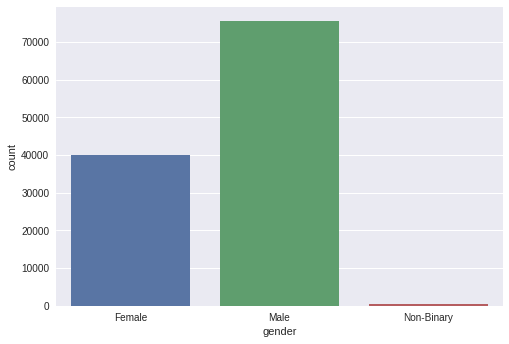

In [0]:
import random
import seaborn as sns

sns.countplot(user_metadata['gender'])

Gender also happens to have some Non-Binary gender. Let's assume 60% are likely to be male according to the distribution

In [0]:
user_metadata.loc[user_metadata['gender']=='Non-Binary','gender'] = 'Male'

In [0]:
#choose random gender by 1/3 to 2/3 ratio
genders = ['Male','Female','Male']
user_metadata['gender'] = user_metadata['gender'].fillna(lambda x: random.choice(genders))

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


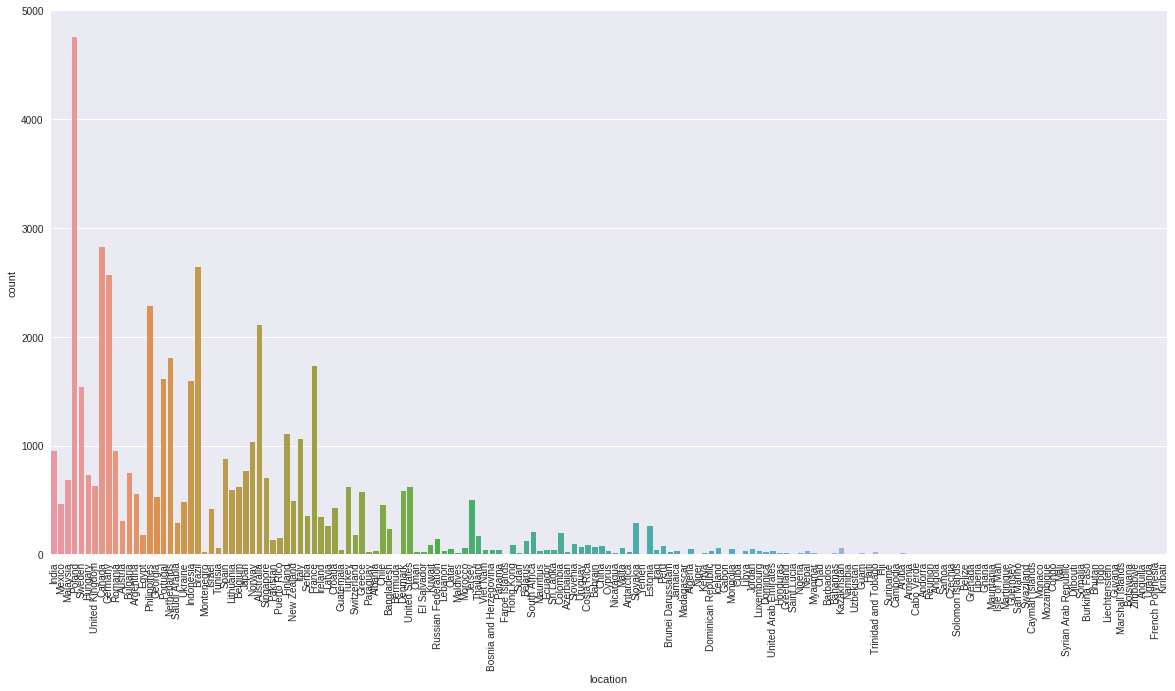

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
sns.countplot(user_metadata['location'])

Interestingly enough Polish people seem to watch a lot of anime and so are a lot of European countries. It's understandable why China and Japan are not on the top lists since myanimelist is an English website

In [0]:
#generate list of countries
country_list = []
for key,item in user_metadata['location'].value_counts().to_dict().items():
  country_list += item*[key]

In [0]:
#fill out missing data according to country distribution in country_list
user_metadata['location'] = user_metadata['location'].fillna(lambda x: random.choice(country_list))

In [0]:
#fill in numeric data with median
median_list = ['stats_mean_score','stats_rewatched','stats_episodes','num_months','age']
for column in median_list:
  user_metadata[column] = user_metadata[column].fillna(user_metadata[column].median())

In [0]:
user_metadata.isna().sum()

user_id                     0
user_watching               0
user_completed              0
user_onhold                 0
user_dropped                0
user_plantowatch            0
user_days_spent_watching    0
gender                      0
location                    0
stats_mean_score            0
stats_rewatched             0
stats_episodes              0
num_months                  0
age                         0
dtype: int64

All filled up!

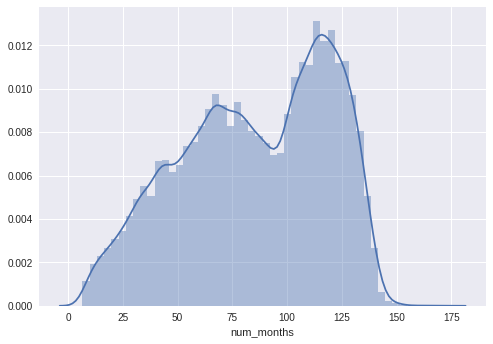

In [0]:
sns.distplot(user_metadata['num_months'])

For num_months features, it seems that we have two normal distribution graphs where most people are either 75 or 110 months into the community

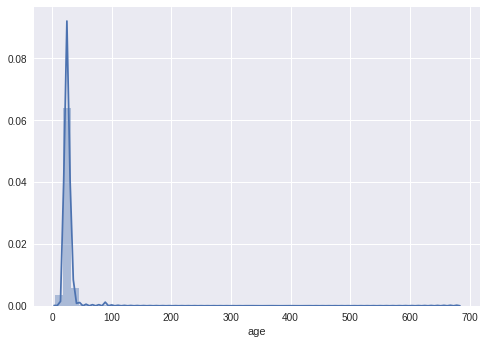

In [0]:
sns.distplot(user_metadata['age'])

The data doesn't seem quite right, there is no way that people lived up to 700 years or people who are older than 80~90 are member of this community. Let's fix that by assigning strange values with mean

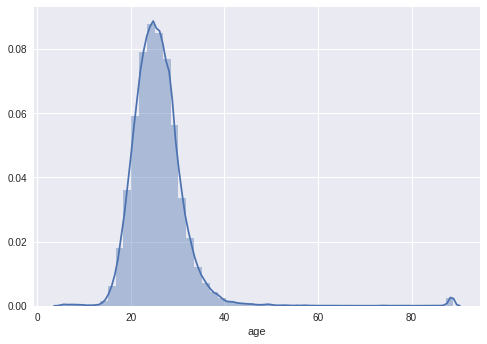

In [0]:
user_metadata.loc[user_metadata['age']>90,'age'] = user_metadata['age'].mean()
sns.distplot(user_metadata['age'])

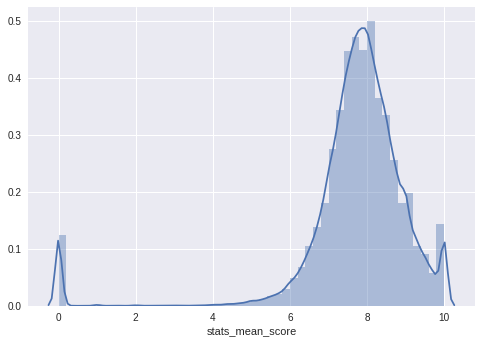

In [0]:
sns.distplot(user_metadata['stats_mean_score'])

Quite abnormal data. It seems that most people give ratings around 7~8 but some people preferto give 10 or 0 to everything they have watched. Let's fix 0 values with median of the data

In [0]:
user_metadata.loc[user_metadata['stats_mean_score']<1,'stats_mean_score'] = user_metadata['stats_mean_score'].median()

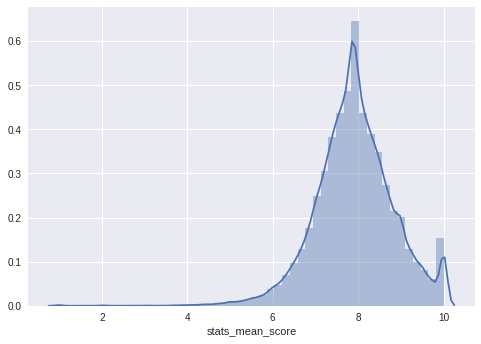

In [0]:
sns.distplot(user_metadata['stats_mean_score'])

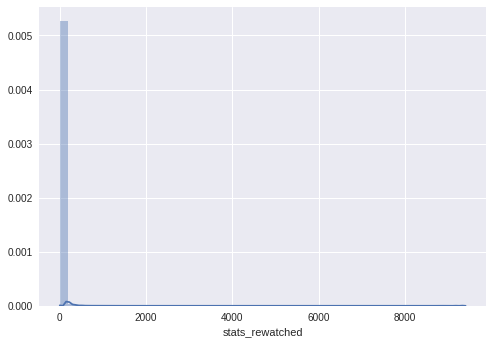

In [0]:
sns.distplot(user_metadata['stats_rewatched'])

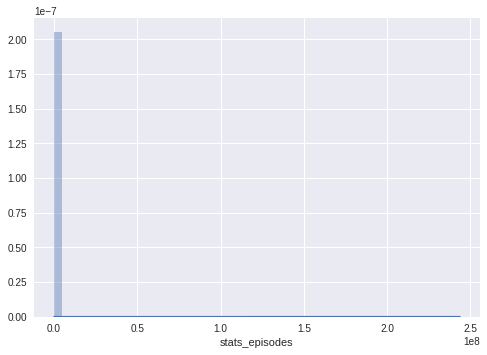

In [0]:
sns.distplot(user_metadata['stats_episodes'])

For both of the episodes and rewatched values, it seems that a lot of people only watch a few episodes or take it to the extreme by watching thousands and thousands of episdoes. Pretty wide distributions of data.

In [0]:
#export processed data
user_metadata.to_csv('/content/gdrive/My Drive/Colab Notebooks/aniRec/data/processed_user.csv')